## Task: Train an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.

You are provided with the code to load the EMNIST train and split **datasets**

Write and train a classifier for EMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on test data.
- Maintain good code quality.

In [27]:
from IPython.display import clear_output

In [28]:
%pip install torch torchvision
%pip install matplotlib

clear_output()

# 0. Previous steps:
Set up the environment for building the neural network so that it can correctly classify the data.

## 0.1. Relevant packages and modules
The zero-th step would be to import all relevant packages and extract from them the modules that are relevant for this project. For the bulk of the project I am only going to use `torch`, `optim`, and `torchvision` (which will help me avoid the trouble of manually building the gradient descent optimization problem for the neural network). In the end though, in order to verify the perofrmance of the model the remaining packages will be used to compute or plot relevant perofrmance metrics.

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F_tv
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Check if we have connected the GPU to the Colab environment, and if it is the case, assign it as the device for PyTorch execution. This will help increase the processing speed of our code.

In [30]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## 0.2. Ensure code reproducibility:
Ensure that we can consistently run the code to obtain the same result and compare performance based on it. Set a seed for the random operations in the code.

In [31]:
# Set random seeds for reproducibility
seed = 80
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# 1. Importing and preprocessing the data:
Before building the model we need to import the data. The data is readily available in the `torch` library but it can be processed before training the model to enhance its performance. We will start with this mormalization first.

## 1.1. Normalization set up
The `torchvision.transforms` module provides a convenient `Normalize` transform for the purpose of centering the data about a zero mean unit standard deviation normal distribution. To apply this, we only need to calculate the mean and standard deviation of the EMNIST dataset to use this method. We need to calculate the mean and standard deviation ourselves by iterating over the full dataset once. The following function implements this:

In [32]:
def calculate_normalization_parameters(dataset):
    # We need to create a dataloader for this one time just
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    # Initialize variables
    mean = 0.0
    var = 0.0
    nb_samples = 0

    # Iterate over the full dataset
    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        var += data.var(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    var /= nb_samples
    std = torch.sqrt(var)

    return mean, std

We need to update the `transform` function to normalize the data directly when these is loaded from the EMIST tool. To do this we need to compute the mean and standard deviation of the dataset and apply it to the transformation. We will do this as follows:

1.   Load the full data set once to compute the mean and standard deviation
2.   Use the previously declared function to obtained these values
3.   Add the `Normalize` transform to the data transformation pipeline

In [33]:
# Temporarily load the dataset without normalization to compute mean and std
temp_transform = transforms.ToTensor()
temp_train_data = EMNIST(root='emnist_data/', split='byclass', download=True, transform=temp_transform)

# Calculate mean and std
mean, std = calculate_normalization_parameters(temp_train_data)
print(f'Mean: {mean}, Std: {std}')

# Define the normalization transform
normalize = transforms.Normalize(mean, std)  # Use precomputed mean and std

# Update the transform to include normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

Mean: tensor([0.1736]), Std: tensor([0.3277])


## 1.2. Import the data
The EMNIST data set is already split into train and test data and the `transform` function is already implemented to normalize the data. Loading it into PyTorch tensors yields,

In [34]:
# Load the EMNIST dataset with the updated transform which takes care of the normalization
train_data = EMNIST(root='emnist_data/', split='byclass', download=True, transform=transforms.ToTensor())
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False, transform=transforms.ToTensor())

The state of the data is also checked in order to verify that the import operation has been successful.

In [35]:
emnist_labels = train_data.classes
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', emnist_labels)

# Choose a particular data point to check that the label and the image match:
demo_img, demo_label = train_data[20]

print(demo_label)
F_tv.resize(demo_img, (255, 255))

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
3


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## 1.3. Create the data loaders
The `DataLoader` from `torch.utils.data` provides us with an efficient way to load data in batches, allowing for parallel loading and shuffling of data, which improves training performance and convergence. This is also necessary since we do not posses the resources to process the whole dataset at once.

We need to select the batch size for these loaders, which determines the number of samples processed before updating the model parameters. A larger batch size provides more accurate estimates of the gradient but requires more memory and can be slower per update, while a smaller batch size is faster and uses less memory but results in noisier and more oscillatory gradient estimates. The choice of batch size depends on the hardware (e.g., GPU memory), the dataset size, and the specific problem. It is often chosen empirically, with common values ranging from 32 to 256. **Goodfellow et al. (2016)** recommend starting with 32 and adjusting based on the training dynamics and hardware constraints. In this case, 32 was set as the initial value, and 64 was seen to perform nicely.

---

I. Goodfellow, Y. Bengio, and A. Courville. 2016. Deep Learning. MIT Press.

In [36]:
batch_size = 64

# Create the data loaders: for the train loader we need the data to be shuffled in each training epoch
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

We can now check that everything has been completed correctly. In order to do so, we may start by checking the sizes of the output.

In [37]:
batch = next(iter(train_loader))
batch[0].shape
# Should print out: [no. img in batch, channels, pixel rows, pixel columns]

torch.Size([64, 1, 28, 28])

In [38]:
# The labels of the images, as many as images in each batch
batch[1].shape

torch.Size([64])

Finally we can print out a full batch to check that the labels match the data and the indexing has been performed correctly.

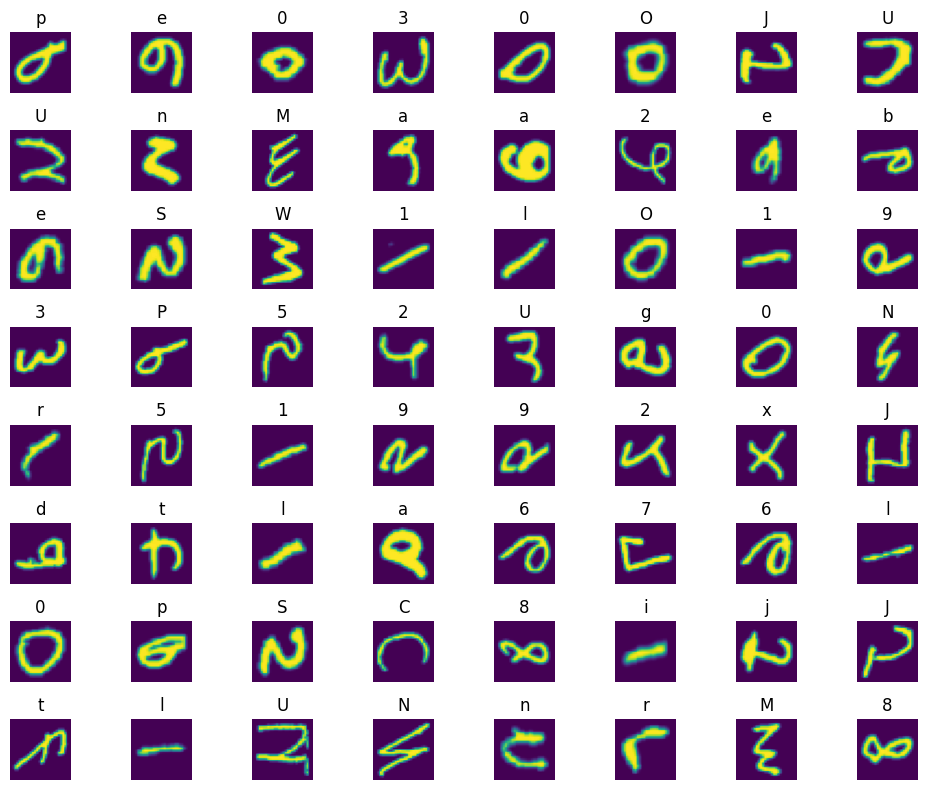

In [39]:
plt.figure(figsize=(10,8))
for i in range(batch[0].shape[0]):
    plt.subplot(int(batch_size/8),8,i+1)
    plt.imshow(batch[0][i,0,:,:])
    plt.title(emnist_labels[batch[1][i].item()])
    plt.axis('off')
plt.tight_layout()

# 2. Building and training the NN:
Now that all the data is loaded and ready for processing, we may build the neural network and train it to perform the classification task at hand.

## 2.1. Declare the NN class

In this case, we use a 3-layer neural network to process the EMNIST dataset. My previous runs have indicated that increasing the network depth to a 4-layer neural network did not yield significant performance improvements. The data is reshaped for the forward pass using the line `x = x.view(-1, self.ni)`, where `ni` represents the number of inputs. This step is important because the total size of the dataset may not be divisible by the batch size, potentially resulting in a final batch smaller than the specified batch size.



---



The network layers are linear layers because they are simple yet effective for this task, providing a straightforward way to compute weighted sums of inputs, which is important to capture patterns in data (Glorot, X., & Bengio, Y., 2010).



> Glorot, X., & Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks. In Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics (pp. 249-256).



We also employ the `ReLU` activation function for the hidden layers as it helps to mitigate the "vanishing gradient problem" and accelerates convergence by introducing non-linearity, allowing the model to learn more complex representations. Using `ReLU` is particularly effective for image data, such as the EMNIST dataset, due to its computational efficiency and ability to handle the inherent sparsity and high dimensionality of image data (Nair, V., & Hinton, G. E., 2010).

> Nair, V., & Hinton, G. E. (2010). Rectified Linear Units Improve Restricted Boltzmann Machines. In Proceedings of the 27th International Conference on Machine Learning (ICML-10) (pp. 807-814).

The final layer does not require an activation function because `PyTorch` handles the activation implicitly when computing loss during training. This approach is typical since the softmax function is included in the loss function (i.e., `CrossEntropyLoss` in `PyTorch`), which combines `LogSoftmax` and `NLLLoss` in a single class for numerical stability and efficiency .

---



During the forward pass, the gradient operation in the `PyTorch` framework automatically computes the gradients and updates the weights, obviating the need to manually track the transformations of each variable. Consequently, **we can overwrite the input x with the output of each layer and activation function sequentially**.

In [40]:
class NN(nn.Module):
  def __init__(self, ni, nh1, nh2, no):
    super(NN, self).__init__()

    # Initialize layers
    self.layer1 = nn.Linear(ni, nh1)
    self.layer2 = nn.Linear(nh1, nh2)
    self.layer3 = nn.Linear(nh2, no)

    # Assign number of inputs as a parameter for use in 'forward'
    self.ni = ni

    self.hidden_activation = nn.ReLU()  # ReLU activation function
    self.softmax = nn.Softmax(dim=1)    # Softmax activation function

  def forward(self, x):
    # never hardcode batch size, since the last batch may not match the batchsize
    x = x.view(-1,self.ni)

    # no need to keep track of each layer, .gradient does this for us, overwrite x
    x = self.layer1(x)
    x = self.hidden_activation(x)

    x = self.layer2(x)
    x = self.hidden_activation(x)

    x = self.layer3(x)

    return x

Implementing a CNN for the EMNIST dataset offers advantages over fully connected networks due to its ability to capture spatial hierarchies (topology) in images through convolutional layers. CNNs learn easily features like edges and textures, which reduces the amount of data necessary for the network to perform better.

The CNN architecture implemented starts with two convolutional layers, each followed by a ReLU activation function and max pooling. The padding in the convolutional layers is set as a function of the kernel size ($\text{padding} = (\text{kernel size} - 1)/2$) to maintain the input size after convolution. This ensures that the spatial dimensions of the image are preserved, which is nice for deeper layers to have enough resolution to extract features. Using a stride of $s=1$ in the convolutional layers further ensures detailed feature extraction without reducing the image dimensions. After the convolutional layers, max pooling is applied to reduce the dimensions of the images and increase the robustness of the features. The flattened output from the convolutional layers is then passed through three fully connected layers, with ReLU activations in between, to perform the final classification, as done previously in the `NN` class.

In [41]:
class CNN(nn.Module):
  def __init__(self, ni, nch1, nch2, kernel_size, nh1, nh2, no):
    super().__init__()

    # Initialize convolutional layers: set padding as a function of the kernel_size to keep size constant. Thus, stride = 1 also
    self.conv1 = nn.Conv2d(1, nch1, kernel_size, 1, int((kernel_size-1)/2))
    self.conv2 = nn.Conv2d(nch1, nch2, kernel_size, 1, int((kernel_size-1)/2))

    # Initialize layers
    self.layer1 = nn.Linear(int(ni/16 * nch2), nh1)
    self.layer2 = nn.Linear(nh1, nh2)
    self.layer3 = nn.Linear(nh2, no)

    # Assign number of inputs as a parameter for use in 'forward'
    self.ni = ni
    self.nch2 = nch2

    #self.hidden_activation = nn.ReLU()        # ReLU activation function
    self.hidden_activation = nn.LeakyReLU()   # Leaky ReLU with default slope 0.01

  def forward(self, x):
    # x ----> (bs, 1, 28, 28)
    x = self.conv1(x)
    x = self.hidden_activation(x)
    # x ----> (bs, nch1, 28, 28)

    x = F.max_pool2d(x, (2,2))
    # x ----> (bs, nch1, 14, 14)

    x = self.conv2(x)
    x = self.hidden_activation(x)
    # x ----> (bs, nch2, 14, 14)

    x = F.max_pool2d(x, (2,2))
    # x ----> (bs, nch2, 7, 7)

    x = x.view(-1,int(self.ni/16 * self.nch2))
    # x ----> (bs, 28*28/4^2 * nch2)

    x = self.layer1(x)
    x = self.hidden_activation(x)

    x = self.layer2(x)
    x = self.hidden_activation(x)

    x = self.layer3(x)

    return x

## 2.2. Design the neural network

The chosen architecture for the neural network includes an input layer with $\frac{(28\times 28) \times 60}{4 \times 4}= (7\times 7) \times 60 = 2940$ neurons, two hidden layers with 450 and 248 neurons respectively, and an output layer with 62 neurons. The input layer size corresponds to the flattened 28x28 pixel images from the EMNIST dataset after being processed by the convolutional layers.

The first hidden layer with 250 neurons strikes a balance between computational efficiency and model complexity, capturing a broad range of features from the input data. Empirical guidelines suggest that the number of neurons in the hidden layers should be between the size of the input and output layers, reducing towards the output to *focus on higher-level abstractions while maintaining computational feasibility* (Heaton, 2018; Chollet, 2017). The second hidden layer with 124 neurons follows this trend, providing a gradual reduction in complexity.

These decissions have been taken based on the recommended numbers often used in practice as given by (Goodfellow et al., 2016),
\begin{align}
n_{h1} = \sqrt{n_i \times n_o} = 426.94 \approx 427 &&
n_{h2} = \frac{n_{h1}}{2} \approx 213
\end{align}
The values choosen are slightly higher that these based on the belief that quite complex structures have to be determined. Also, in practice they seem to perform better without overfitting.



---

Chollet, F. (2017). Deep Learning with Python. Manning Publications.

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.

Heaton, J. (2018). Ian Goodfellow, Yoshua Bengio, and Aaron Courville: Deep Learning. Genetic Programming and Evolvable Machines, 19(1), 305-307.

In [42]:
# Establish the number of neurons per layer
ni = 28*28
nh1 = 450
nh2 = 248
no = 62

# Initialize the model:
net = NN(ni,nh1,nh2,no).to(device)
# We need to send all input tensors as well as our model to this device, since by default, they are on cpu

# Initialize a convolution neural network: self, ni, nch1, nch2, kernel_size, nh1, nh2, no
nch1 = 40
nch2 = 60
kernel_size = 3
net = CNN(ni,nch1,nch2,kernel_size,nh1,nh2,no).to(device)

The number of training epochs chosen follows a completely empirical decission, following the logic of early stopping to avoid overfitting. The number of epochs is designed such that it arrives up to the point where the loss platoes.

Some momentum is added to avoid oscillations when converging towards the minimum value of the function.

The optimizer chosen is simply `SGD` (Stochastic Gradient Descent), which will take steps in the negative gradient direction of the output.

Finally, concerning the learning rate, a large initial value of $lr=0.05$ has been chosen to avoid long convergence times towards the minimum value of the loss function. However, in order to improve performance further, and adaptive learning rate has been introduced, which can be done using learning rate schedulers provided by the `torch.optim.lr_scheduler` module. These schedulers adjust the learning rate during training based on a predefined schedule or conditions. I tried:

*   `StepLR`: decays the learning rate by a predefined factor every predefined number of epochs.
*   `ReduceLROnPlateau`: reduces the learning rate when some chosen metric has stopped improving.
*   `ExponentialLR`: decays the learning rate exponentially by some predefined factor each epoch.

of which the one that worked best was the `ExponentialLR` with a decay factor of $\gamma=0.8$. So that $lr_{i+1} = \gamma\times lr_i$ for each epoch $i$.


In [43]:
# Establish the training parameters
num_epochs = 8
lr = 0.05
momentum = 0.5

# Define the optimizer
opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

# Define the learning rate scheduler
scheduler = ExponentialLR(opt, gamma=0.7)

## 2.3. Main training loop

We may now implement the main training loop for our neural network. The loop iterates over the specified number of epochs, performing the forward and backward passes on the training data to update the model's weights. After each epoch, we evaluate the model's performance on the validation set to monitor progress and adjust the learning rate accordingly.

The training and validation losses are recorded to track the model's learning curve, and the accuracy on the validation set is printed to provide insight into the model's performance in each succesive epoch.

In [44]:
# Initialize the value of the losses
train_losses = []
val_losses = []
accuracy = []

# Training loop for multiple epochs
for epoch in range(num_epochs):
  total_loss = 0

  # Training phase for epoch i
  for batch in train_loader:
    x = batch[0].to(device)                 # Move input to device (CPU/GPU)
    y = batch[1].to(device)                 # Move labels to device (CPU/GPU)

    logits = net(x)                         # Forward pass (as defined in the class)
    loss = F.cross_entropy(logits,y)        # Compute loss for this batch
    total_loss += loss.item()               # Accumulate loss for all batches

    opt.zero_grad()                         # Zero gradients from previous step
    loss.backward()                         # Backward pass to compute gradients
    opt.step()                              # Update model parameters

  epoch_loss = total_loss/len(train_loader) # Compute average training loss
  train_losses.append(epoch_loss)           # Store training loss

  # Validation phase for epoch i
  error = 0
  total = 0
  total_loss_test = 0

  for batch in test_loader:
    x = batch[0].to(device)                 # Move input to device (CPU/GPU)
    y = batch[1].to(device)                 # Move labels to device (CPU/GPU)

    total += x.shape[0]                     # Accumulate total number of samples in batch i

    logits = net(x)                         # Forward pass (as defined in the class)
    loss = F.cross_entropy(logits,y)        # Compute loss for this batch
    total_loss_test += loss.item()          # Accumulate loss for all batches

    yhat = torch.argmax(logits, dim=1)      # Get predicted labels
    error += torch.sum(yhat!=y)             # Count misclassified samples

  correctly_labelled = total-error          # Compute number of correctly labelled samples
  epoch_loss_test = total_loss_test/len(test_loader) # Compute average validation loss
  val_losses.append(epoch_loss_test)        # Store validation loss of epoch i
  accuracy.append(correctly_labelled/len(test_loader.dataset)*100) # Store accuracy of epoch i

  scheduler.step() # Adjust learning rate for next epoch

  # Print out the results for epoch i in the terminal
  print(f'Epoch: {epoch}, train_loss={epoch_loss}, valiation_loss={epoch_loss_test}, labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

Epoch: 0, train_loss=0.5394867309067701, valiation_loss=0.41132256041134413, labelled 99041/116323 correctly (85.14309692382812% accuracy)
Epoch: 1, train_loss=0.3737514079725187, valiation_loss=0.38354683981345694, labelled 99940/116323 correctly (85.91593933105469% accuracy)
Epoch: 2, train_loss=0.3457944223200556, valiation_loss=0.3568148880713385, labelled 100959/116323 correctly (86.79195404052734% accuracy)
Epoch: 3, train_loss=0.3286745698817516, valiation_loss=0.352208421712104, labelled 101008/116323 correctly (86.83407592773438% accuracy)
Epoch: 4, train_loss=0.3163397952739348, valiation_loss=0.3444310202620866, labelled 101409/116323 correctly (87.17880249023438% accuracy)
Epoch: 5, train_loss=0.3067587449239434, valiation_loss=0.3429831878719616, labelled 101254/116323 correctly (87.0455551147461% accuracy)
Epoch: 6, train_loss=0.2996378043581428, valiation_loss=0.341459971511423, labelled 101447/116323 correctly (87.21147155761719% accuracy)
Epoch: 7, train_loss=0.2940284

# 3. Evaluate model performance:
Now that the model has been trained and tested already during its training, it is useful to visualize its evolution and check its actual performance as a pure predictor.

## 3.1. Visualize training process

Visualizing the training process may help us understand how our neural network learns from the data over epochs. The following graph plots the evolution of both training and validation losses throughout the training phase. This allows us to observe how well the model generalizes to unseen data compared to the training data, which may also show signs of overfitting if this existed in the model.

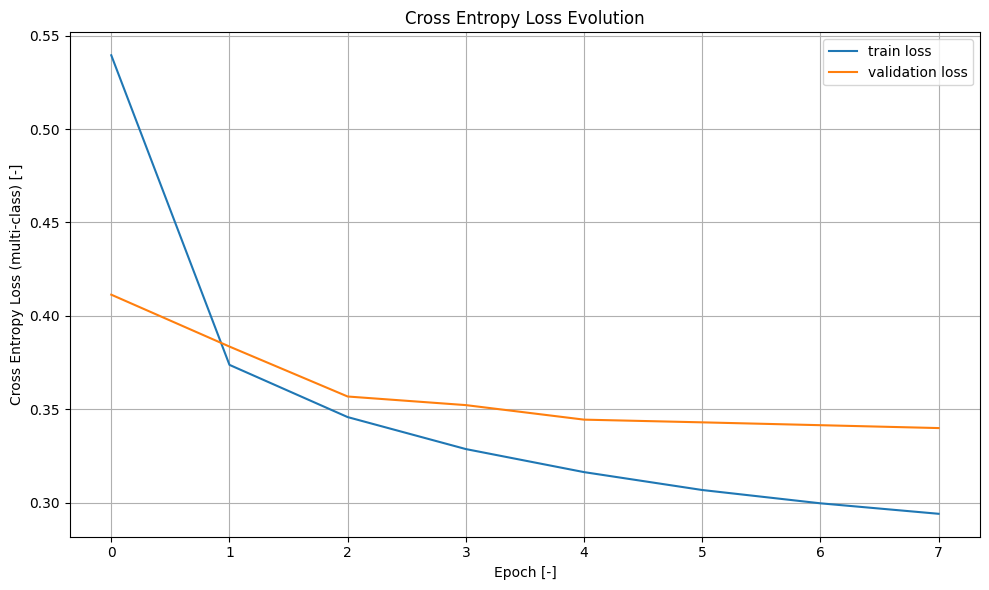

In [45]:
# Figure settings:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='train loss')            # Plot training loss
plt.plot(val_losses, label='validation loss')         # Plot validation loss

# Graph formatting:
plt.xlabel('Epoch [-]')
plt.ylabel('Cross Entropy Loss (multi-class) [-]')
plt.title('Cross Entropy Loss Evolution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Monitoring the validation accuracy provides similar insights as the losses above. The graph below visualizes the evolution of accuracy achieved on the validation set throughout the training process, highlighting the maximum accuracy attained as a dashed horizontal line for reference.

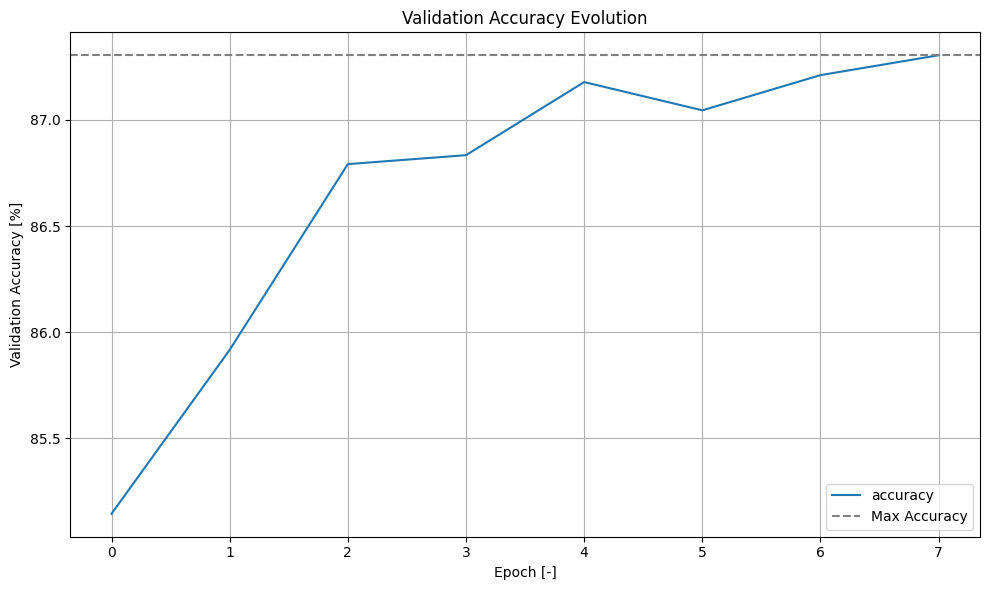

In [46]:
# Calculate maximum validation accuracy
accuracy_tensor = torch.tensor(accuracy)
accuracy_cpu = accuracy_tensor.to('cpu').numpy()
max_accuracy = max(accuracy_cpu)

# Figure settings:
plt.figure(figsize=(10,6))
plt.plot(accuracy_cpu, label='accuracy')      # Plot validation accuracy
plt.axhline(y=max_accuracy, color='gray', linestyle='--', label='Max Accuracy')   # Plot max accuracy line

# Graph formatting:
plt.xlabel('Epoch [-]')
plt.ylabel('Validation Accuracy [%]')
plt.title('Validation Accuracy Evolution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Another interesting graph to illustrate model performance is the learning rate scheduler. This graph shows how the learning rate changes over epochs as dictated by the scheduler, which can significantly impact model convergence and final performance.

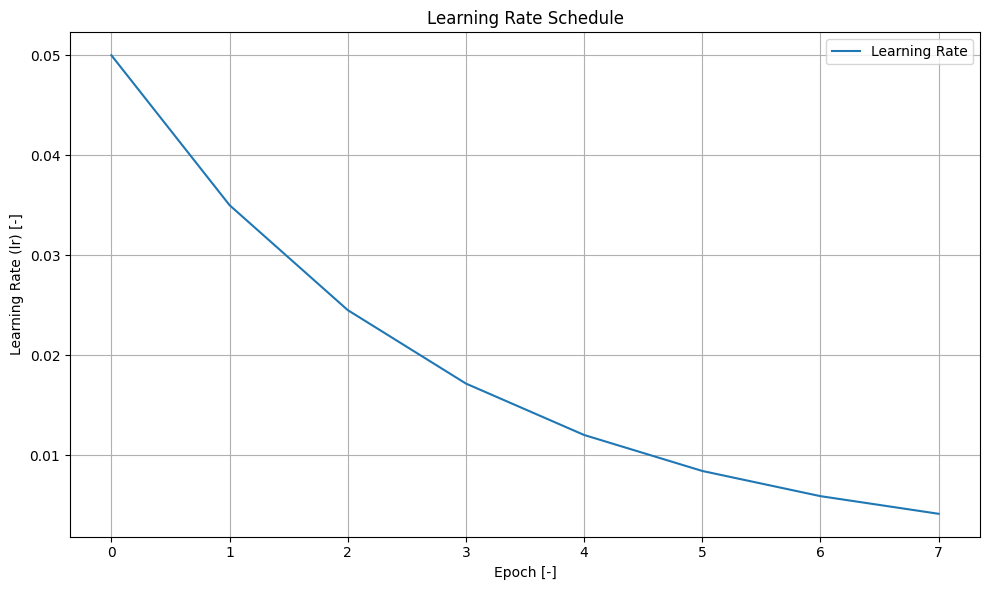

In [47]:
# Initialize list to store learning rates
learning_rates = []

# Assuming `scheduler` is already defined and associated with the optimizer
for epoch in range(num_epochs):
    scheduler.step()  # Update the learning rate
    learning_rates.append(scheduler.get_last_lr()[0]/(0.7**(num_epochs+1)))  # Log the current learning rate

# Figure settings:
plt.figure(figsize=(10,6))
plt.plot(range(num_epochs), learning_rates, label='Learning Rate')

# Graph formatting:
plt.xlabel('Epoch [-]')
plt.ylabel('Learning Rate (lr) [-]')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.2. Verify performance numerically:

A final step would be to manually verify our previous accuracy computations by making the neural network predict a random set of values in the test data set. Counting the errors in classification we can obtain both the error percentage and the accuracy again.

In [48]:
# Initialize the variables
error = 0
total = 0
y_pred = []
y_true = []

# Iterate over the test data
for batch in test_loader:
  X = batch[0].to(device)
  y = batch[1].to(device)
  total += X.shape[0]                     # Add up all data points

  logits = net(X)                         # Forward pass (as implemented)
  yhat = torch.argmax(logits, dim=1)      # Get predicted labels
  error += torch.sum(yhat!=y)             # Count misclassified samples

  y_pred.extend(yhat.cpu().numpy())       # Store predicted labels
  y_true.extend(y.cpu().numpy())          # Store true labels

# Compute relevant metrics
accuracy = (total-error)/total*100
error_percentage = error/total*100

# Print out the results
print(f"The error percentage is {error_percentage:.3f}%, equivalent to an accuracy of {accuracy:.3f}% with a total of {int(error)} errors in {int(total)} samples.")

The error percentage is 12.695%, equivalent to an accuracy of 87.305% with a total of 14767 errors in 116323 samples.


### Accuracy
Accuracy is the ratio of correctly predicted instances to the total instances. It is defined as:
\begin{equation}
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation}

where:
- $TP$ = True Positives
- $TN$ = True Negatives
- $FP$ = False Positives
- $FN$ = False Negatives

In [49]:
# Evaluate the model and display the metric:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8730517610446773


### Classification Report
The classification report provides the following performance evaluation metrics:

- **Precision** is the ratio of correctly predicted positive observations to the total predicted positives:
  \begin{equation}  \text{Precision} = \frac{TP}{TP + FP} \end{equation}

- **Recall** (or Sensitivity) is the ratio of correctly predicted positive observations to all observations in the actual class:
  \begin{equation}  \text{Recall} = \frac{TP}{TP + FN} \end{equation}

- **F1-Score** is the weighted average of Precision and Recall, one can think of it as the equivalent resistance in parallel, where the two must balance out to give nice results:
  \begin{equation}  \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} \end{equation}

In [50]:
# Evaluate the model and display the metric:
class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76      5778
           1       0.69      0.91      0.79      6330
           2       0.96      0.98      0.97      5869
           3       0.99      0.99      0.99      5969
           4       0.97      0.98      0.98      5619
           5       0.96      0.95      0.95      5190
           6       0.97      0.98      0.98      5705
           7       0.99      0.99      0.99      6139
           8       0.98      0.99      0.98      5633
           9       0.93      0.98      0.96      5686
          10       0.95      0.97      0.96      1062
          11       0.92      0.96      0.94       648
          12       0.78      0.93      0.85      1739
          13       0.90      0.91      0.90       779
          14       0.96      0.97      0.97       851
          15       0.80      0.92      0.85      1440
          16       0.93      0.89      0.91       447
    

# 4. Save the trained model:
To avoid having to rerun the training in order to use the model that was built in the previous section, we can save the actual state of the trained model in our main directory.

In [51]:
# save the model's state dict to avoid having to rerun everything
torch.save(net.state_dict(), 'MNIST_classifier.pt')

We can load the model and compute the predictions in one batch just to check that the loading is correct and thus the model has also been saved correctly in our computer's memory.

In [52]:
# Instantiate the neural network model, set it to evaluation mode and move it to the appropriate device
loaded_model = CNN(ni, nch1, nch2, kernel_size, nh1, nh2, no)
loaded_model.eval().to(device)

print('Before loading model')

# Perform prediction with the untrained model
with torch.no_grad():
    probs = loaded_model(X)       # Calculate predictions
    preds = probs.argmax(dim=1)   # Determine predicted classes

    # Print the number of correct predictions out of the total
    print(f'{(preds==y).sum()}/{len(preds)} correct')

print('After loading model')

# Load the trained model state
loaded_model.load_state_dict(torch.load('MNIST_classifier.pt'))

# Perform prediction with the loaded model
with torch.no_grad():
    probs = loaded_model(X)       # Calculate predictions
    preds = probs.argmax(dim=1)   # Determine predicted classes

    # Print the number of correct predictions out of the total
    print(f'{(preds==y).sum()}/{len(preds)} correct')

Before loading model
1/35 correct
After loading model
30/35 correct
